In [1]:
import scanpy as sc
import os
import bin2cell as b2c
import celltypist
from celltypist import models
import numpy as np
from matplotlib import rcParams
from matplotlib import font_manager
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation
from PIL import Image

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [2]:
cdata = sc.read_h5ad('../Example_Data/H1-TXK6Z4X-A1_2um/skin_TXK6Z4X_A1_2um_b2c.h5ad')
cdata

AnnData object with n_obs × n_vars = 114213 × 17079
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [10]:
cdata = cdata[cdata.obs['bin_count']>7] # min 8 bins
#need integers for seuratv3 hvgs
cdata.X.data = np.round(cdata.X.data)
cdata.raw = cdata.copy()

In [11]:
cdata.var["mt"] = cdata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(cdata, qc_vars=["mt"], percent_top=[20], inplace=True)

cdata

AnnData object with n_obs × n_vars = 84110 × 17079
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

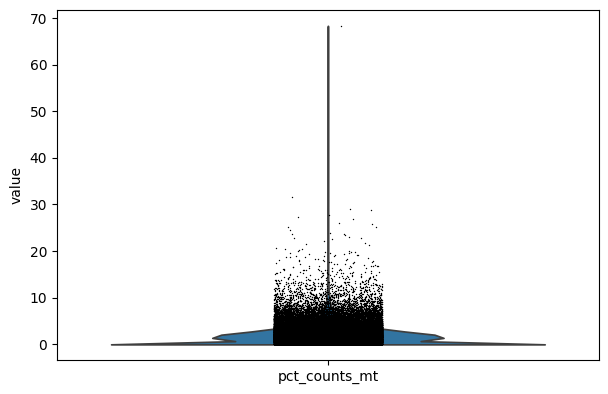

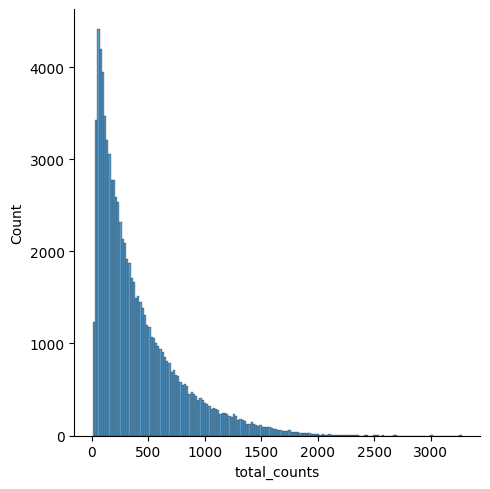

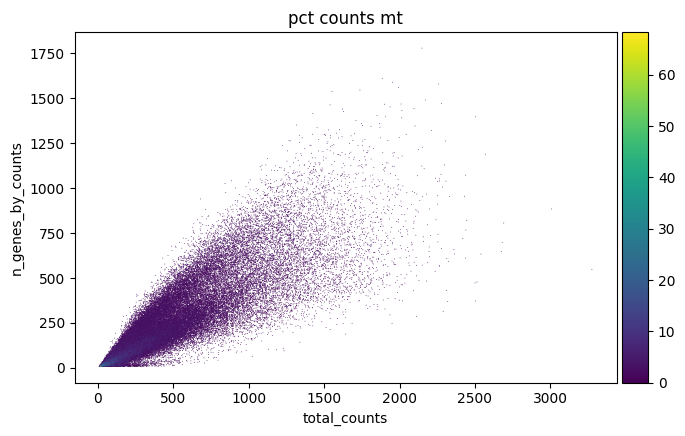

In [12]:
p1 = sc.pl.violin(cdata, "pct_counts_mt")
p2 = sns.displot(cdata.obs["total_counts"])
p3 = sc.pl.scatter(cdata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [13]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [14]:
cdata.obs["outlier"] = (
    is_outlier(cdata, "log1p_total_counts", 5)
    | is_outlier(cdata, "log1p_n_genes_by_counts", 5)
    | is_outlier(cdata, "pct_counts_in_top_20_genes", 5)
)
cdata.obs.outlier.value_counts()

outlier
False    84110
Name: count, dtype: int64

In [15]:
cdata.obs["mt_outlier"] = is_outlier(cdata, "pct_counts_mt", 3) | (
    cdata.obs["pct_counts_mt"] > 8
)
cdata.obs.mt_outlier.value_counts()

mt_outlier
False    78865
True      5245
Name: count, dtype: int64

In [16]:
print(f"Total number of cells: {cdata.n_obs}")
cdata = cdata[(~cdata.obs.outlier) & (~cdata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {cdata.n_obs}")

Total number of cells: 84110
Number of cells after filtering of low quality cells: 78865


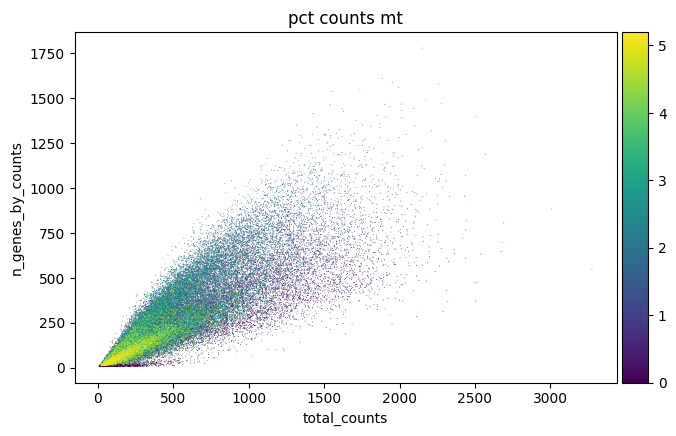

In [17]:
p1 = sc.pl.scatter(cdata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [18]:
sc.pp.normalize_total(cdata,target_sum=1e4)
sc.pp.log1p(cdata)
sc.pp.highly_variable_genes(cdata,n_top_genes=5000,flavor="seurat_v3")
b2c_predictions = celltypist.annotate(cdata, model = 'Adult_Human_Skin.pkl')
cdata = b2c_predictions.to_adata()
cdata

🔬 Input data has 78865 cells and 17079 genes
🔗 Matching reference genes in the model
🧬 2945 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


AnnData object with n_obs × n_vars = 78865 × 17079
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_labels', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [96]:
cdata = cdata[:, cdata.var["highly_variable"]]
sc.pp.scale(cdata, max_value=10)
sc.pp.pca(cdata, use_highly_variable=True)
sc.pp.neighbors(cdata)
sc.tl.umap(cdata)

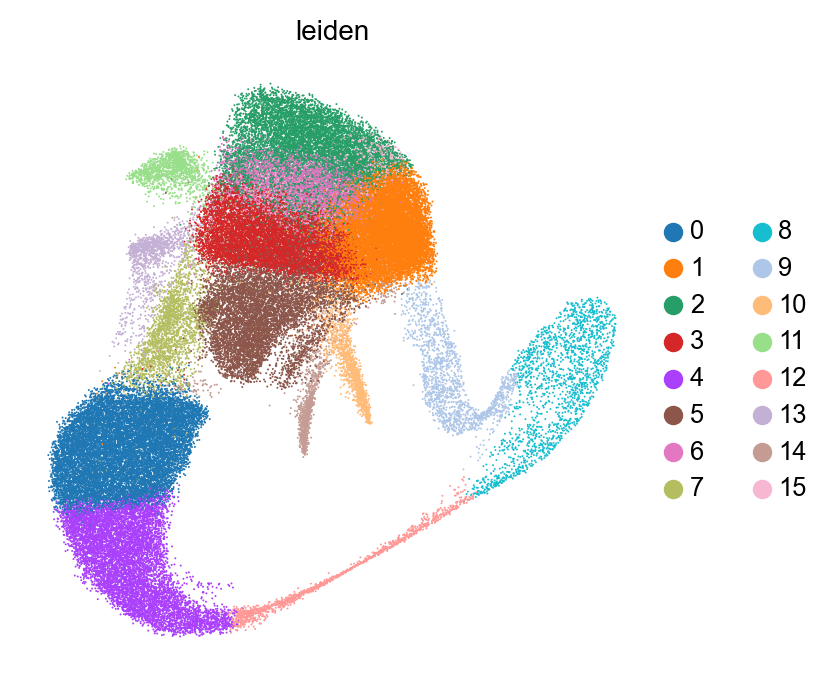

In [97]:
sc.set_figure_params(dpi=100,fontsize=10,)

sc.tl.leiden(cdata,resolution=1,key_added='leiden')
sc.pl.umap(cdata,color=['leiden'],size=2,wspace=0.25,frameon=False)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


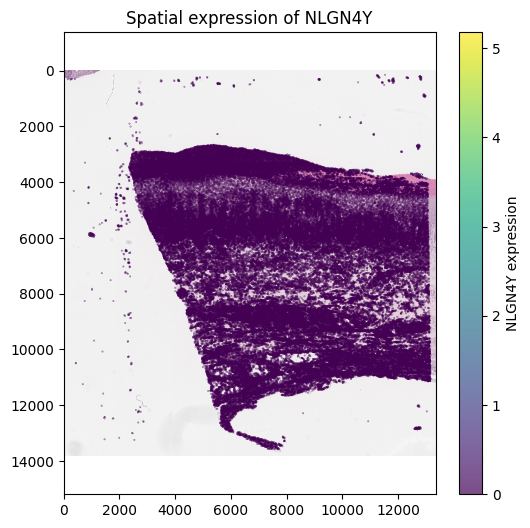

In [7]:
# spatial expression of NLGN4Y

gene = "NLGN4Y"

bg_img = Image.open("../Example_Data/H1-TXK6Z4X-A1_2um/H1-TXK6Z4X-A1_2um_lite.jpeg")
bg_width, bg_height = bg_img.size

coords = cdata.obsm["spatial_cropped_150_buffer"]
expr = cdata[:, gene].X.toarray().flatten()

plt.figure(figsize=(6, 6))
plt.imshow(bg_img, extent=[0, bg_width, bg_height, 0])
plt.scatter(coords[:, 0], coords[:, 1], c=expr, cmap="viridis", s=0.1, alpha=0.7)
plt.colorbar(label=f"{gene} expression")
plt.title(f"Spatial expression of {gene}")
plt.axis("equal")
plt.xlim(0, bg_width)
plt.ylim(bg_height, 0) 
plt.show()


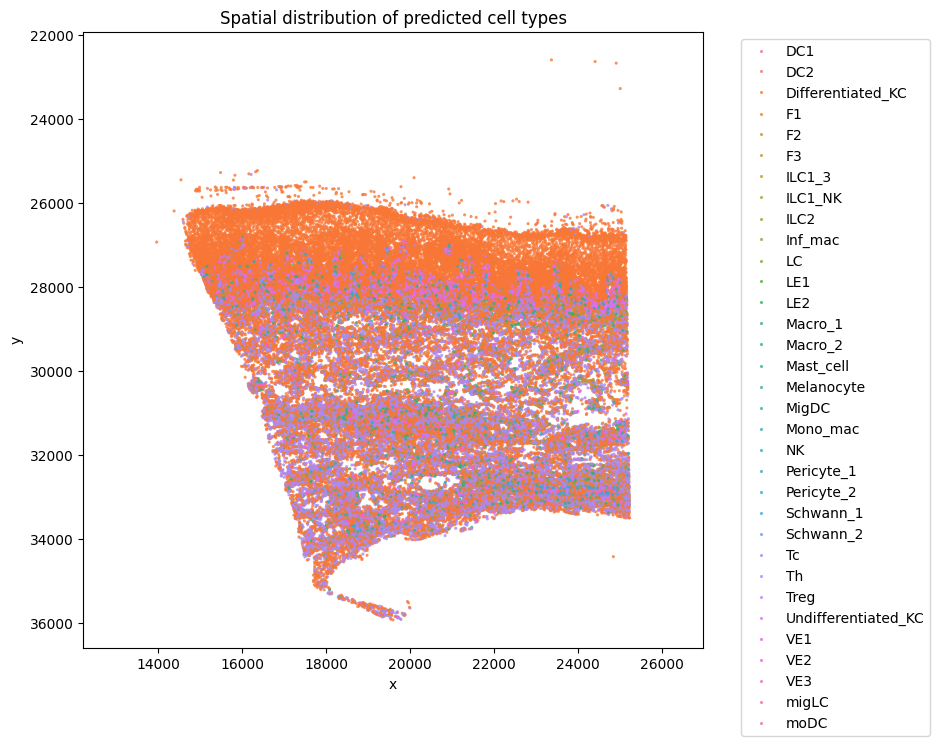

In [21]:
coords = cdata.obsm["spatial"]
labels = cdata.obs["predicted_labels"]

df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "cell_type": labels
})

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x="x", y="y", hue="cell_type", s=5, alpha=0.8, linewidth=0)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Spatial distribution of predicted cell types")
plt.axis("equal")
plt.show()

In [100]:
# Show cell/gene expression matrix
expr_matrix = cdata.X
if not isinstance(expr_matrix, np.ndarray):
    # if sparse matrix, convert to dense
    expr_matrix = expr_matrix.toarray()

df_expr = pd.DataFrame(
    data=expr_matrix,
    index=cdata.obs_names,      # cell id
    columns=cdata.var_names     # gene name
)

df_expr

,HES4,ISG15,TNFRSF4,SCNN1D,MXRA8,TMEM240,MMP23B,SKI,TNFRSF14,MMEL1,...,TKTL1,FLNA,GAB3,MPP1,F8,CMC4,CLIC2,SRY,DDX3Y,NLGN4Y
1,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
2,-0.087931,10.000000,-0.036824,9.276591,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
3,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
4,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
7,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167195,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
167216,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
167229,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926
167242,-0.087931,-0.088713,-0.036824,-0.074214,-0.248176,-0.047049,-0.0489,-0.219451,-0.121928,-0.006054,...,-0.005852,-0.200012,-0.052838,-0.121572,-0.03778,-0.11479,-0.06505,-0.006635,-0.134407,-0.008926


In [101]:
# cell prediction
df_prediction = cdata.obs[['object_id', 'predicted_labels', 'conf_score']].copy()
df_prediction

,object_id,predicted_labels,conf_score
1,1,Differentiated_KC,1.000000
2,2,Differentiated_KC,0.999727
3,3,Differentiated_KC,1.000000
4,4,Differentiated_KC,1.000000
7,7,Differentiated_KC,1.000000
...,...,...,...
167195,167195,Differentiated_KC,0.908546
167216,167216,Differentiated_KC,0.276316
167229,167229,Th,0.174594
167242,167242,Th,0.912805


In [102]:
# showing conf_score > 0.9
df_prediction_09 = cdata.obs[cdata.obs['conf_score'] > 0.9]
df_prediction_09

,object_id,bin_count,array_row,array_col,labels_joint_source,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier,mt_outlier,predicted_labels,conf_score,leiden
1,1,50,920.340000,2428.100000,primary,278,5.631212,1370.696168,7.223803,43.041231,0.000000,0.000000,0.000000,False,False,Differentiated_KC,1.000000,8
2,2,43,919.674419,2356.279070,primary,245,5.505332,1073.785351,6.979876,44.315352,0.000000,0.000000,0.000000,False,False,Differentiated_KC,0.999727,8
3,3,47,905.829787,2483.510638,primary,233,5.455321,1078.193915,6.983970,44.849023,0.000000,0.000000,0.000000,False,False,Differentiated_KC,1.000000,8
4,4,46,918.717391,2404.304348,primary,266,5.587249,1115.189745,7.017676,44.594932,0.000000,0.000000,0.000000,False,False,Differentiated_KC,1.000000,8
7,7,44,919.181818,2307.500000,primary,286,5.659482,1228.412382,7.114292,44.024606,0.000000,0.000000,0.000000,False,False,Differentiated_KC,1.000000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166712,166712,9,2661.444444,668.111111,secondary,25,3.258097,47.550943,3.882614,83.458381,1.768671,1.018367,3.719528,False,False,Differentiated_KC,0.967360,2
166805,166805,11,2583.181818,159.090909,secondary,53,3.988984,127.471738,4.855709,52.346071,0.000000,0.000000,0.000000,False,False,Th,0.909953,10
166821,166821,12,2556.500000,342.000000,secondary,54,4.007333,172.278649,5.154901,59.049713,1.546649,0.934778,0.897760,False,False,Differentiated_KC,0.991506,1
167195,167195,8,2547.000000,789.500000,secondary,51,3.951244,134.184431,4.906640,50.198498,0.000000,0.000000,0.000000,False,False,Differentiated_KC,0.908546,5


In [103]:
cdata.raw.to_adata().write('skin_TXK6Z4X_A1_2um_b2c_qc.h5ad')